<a href="https://colab.research.google.com/github/mohammedlokma/spam_classification/blob/main/Copy_of_Exercise_SPAM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SMS Spam Classification




In this exercise, we will solve the problem of spam SMS classification using perceptron. 

In [3]:
## Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output


# For reproducibility of results.
np.random.seed(11111)

### Load SMS SPAM dataset

You should download the SMS Spam Collection dataset from the  link
below:

https://archive.ics.uci.edu/ml/datasets/sms+spam+collection


then upload **SMSSpamCollection** file to the colab environment.

**Note**: You will need to do this everytime you connect to a new Colab environment.

In [4]:
## Read the SMS spam dataset
spam_data = pd.read_csv('SMSSpamCollection', sep='\t',header=None,names=["label", "text"])


Let's look at some examples of the data and their labels.

In [5]:
spam_data.head(n=20)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [6]:
## Count how many SPAM and ham messages
spam_data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In order to test the algorithm on examples not seen during the training, let's split the dataset into two parts : training and test subsets.

In [7]:
def train_test_split(data, train_ratio=0.75):
  """ Utility function to randomly split input data frame into training and 
  test subsets.
  params:
  train_ratio: percentage of examples that goes into training subset.
  """
  num_data = spam_data.shape[0]
  num_train = int(num_data * train_ratio)
  all_idx = np.arange(num_data)
  train_idx = all_idx[:num_train]
  test_idx = all_idx[num_train:]
  train_data = data.iloc[train_idx]
  test_data = data.iloc[test_idx]
  return train_data, test_data

In [8]:
spam_train, spam_test = train_test_split(spam_data)
print("Training set size: ", spam_train.shape[0])
print("Test set size: ", spam_test.shape[0])

Training set size:  4179
Test set size:  1393


## Bag of Words Feature Representation

The input examples are represented as text. We need to transform them each text message into a vector of numbers which we can process using our neural network.

We will use a simple method called **Bag of words**. You can read about the bag of words approach in the links below:


*   https://machinelearningmastery.com/gentle-introduction-bag-words-model/
*   https://en.wikipedia.org/wiki/Bag-of-words_model



To process the input text using bag of words, we need to build a vocabulary to maps each unique word (ignoring the letters case) to a unique integer.

Let's start by creating a vocabulary dictionary which counts the number of times each unique (ignoring casing) word appears in the training data.

In [9]:
def build_word_counts(data):
  """ A function that builds a dictionary with the counts of each word occurs 
  in the dataset. Ignore the letter casing."""
  vocab = {}
  for idx, row in data.iterrows():
    row_text = row.text
    row_words = row_text.split(' ')
    row_words=[w.lower() for w in row_words]
    for w in row_words:
      if w in vocab:
        vocab[w] += 1
      else:
        vocab[w] = 1
  return vocab



In [10]:
vocab = build_word_counts(spam_train)


Now, let's generate the mapping of each word to a unique number. We will also ignore words that were found only few times in the training data (less than $min\_count$).

In [11]:
def build_word_index(vocab, min_count=10):
  word_index = {}
  cur_index = 0
  for word, count in vocab.items():
    if count > min_count:
      if not word in word_index:
        word_index[word] = cur_index
        cur_index += 1
  return word_index

In [12]:
word_to_index = build_word_index(vocab, min_count=10)

In [13]:
def generate_input_target_matrix(data, word_index):
  """ Helper function to transform the input data using the bag of words approach
  params:
  data: input data frame containing examples of text and labels.
  word_index: dictionary that maps each unique word to a unique integer number.
  """

  num_examples = data.shape[0]
  num_words = len(word_index)
  y = np.zeros(shape=(num_examples,), dtype=np.int32)

  X = np.zeros(shape=(num_examples, num_words+1), dtype=np.float32)
  # Number of columns in X = number of words in the word_index + 1. The last
  # column corresponds to unknown words (UNK) which are not found the word_index.
  for row_idx in range(num_examples):
    row = data.iloc[row_idx]
    row_text = row.text
    row_words = row_text.split(" ")
    row_words = [w.lower() for w in row_words]
    for w in row_words: 
      if w in word_index : 
        X[row_idx,word_index[w]] += 1
      else:
        X[row_idx,num_words] += 1  
   
    label = row.label
    if label=='spam':
      y[row_idx] = 1
  return X, y


To test your implementation of the `generate_input_target_matrix`, you can use the following unit test.

In [14]:
test_data = pd.DataFrame({
    'text':['i like playing football', 'football is popular'],
    'label':[ 'ham', 'spam']} )
test_word_index = {'i':0, 'football':1, 'playing': 2, 'like':3} 

test_output_X, test_output_y = generate_input_target_matrix(test_data, test_word_index)

np.testing.assert_equal(test_output_X, np.array([[1., 1, 1., 1., 0],[0., 1., 0., 0., 2.]]))

np.testing.assert_equal(test_output_y, np.array([0, 1]))
print("Looks OK !!")

Looks OK !!


#### Prepare training and testing data 

In [15]:
train_X, train_y = generate_input_target_matrix(spam_train, word_to_index)
test_X, test_y = generate_input_target_matrix(spam_test, word_to_index)

# Perceptron Learning

In [16]:
class Perceptron:
  def __init__(self, learning_rate=0.1, num_features=2):
    self.num_features=num_features
    self.w = np.random.rand(self.num_features+1,)
    self.lr = learning_rate

  def predict(self, input_x):
    """ Helper function to perform prediction on given example """
    xAddBias = np.hstack((1,input_x))
    pred = (np.dot(xAddBias, self.w) > 0).astype(np.float32)
    return pred

  def compute_accuracy(self, X, y):
    m = X.shape[0]
    correct = 0
    for i in range(m):
      pred = self.predict(X[i,:])
      if pred == y[i]:
        correct += 1
    return float(correct) / m

  def train_one_epoch(self, train_X, train_y):
    """ Function to perform one epoch of training using all given examples.
    returns True if the algorithm has correct prediction for all given examples.
    """
    converged = True
    m = train_X.shape[0]
    new_w = self.w.copy()
    for i in range(m) : 
      cur_x = train_X[i,]
      pred = self.predict(cur_x)
      e = train_y[i] - pred
      if e != 0:
        xAddBias = np.hstack((1, cur_x))
        new_w = new_w + e*self.lr * xAddBias
        converged = False
    self.w = new_w
    return converged    


step = :  299
Training set accuracy:  0.9810959559703278
Testing set accuracy:  0.9741564967695621


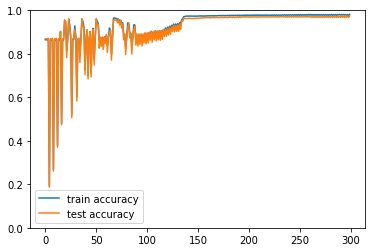

In [17]:
perceptron = Perceptron(learning_rate=0.01, num_features=train_X.shape[1])
test_accuracy_list = []
train_accuracy_list = []
for step_idx in range(300):
  clear_output(wait=True)
  is_converged = perceptron.train_one_epoch(train_X, train_y)
  cur_train_accuracy = perceptron.compute_accuracy(train_X, train_y)
  cur_test_accuracy = perceptron.compute_accuracy(test_X, test_y)
  train_accuracy_list.append(cur_train_accuracy)
  test_accuracy_list.append(cur_test_accuracy)
  print('step = : ',step_idx)
  print('Training set accuracy: ', cur_train_accuracy)
  print('Testing set accuracy: ', cur_test_accuracy)
  plt.plot(train_accuracy_list, label='train accuracy')
  plt.plot(test_accuracy_list, label='test accuracy')
  plt.ylim(0,1)
  plt.legend()
  plt.show()
  if is_converged:
    break



## Analyze the model

Let's now inspect the final model and try to understand how does it work.

We will explore what are the most important features to predict a message is SPAM and what are the most important words. to predict a message is HAM.

In [18]:
final_weights = perceptron.w

Let's start by building an inverted index dictionary that maps an index number of our feature vector to the corresponding word.

In [19]:
index_to_word = {}
for k,v in word_to_index.items():
  index_to_word[v] = k

The most important words to predict a message is SPAM are words that have the largest positive weight.

In [20]:
top_spam_words_idx = np.argsort(final_weights)[-20:]
top_spam_words = [index_to_word[idx] for idx in top_spam_words_idx]
print(top_spam_words)

['0800', 'a', 'r', 'has', 'services', 'dont', 'final', 'play', 'pounds', 'sorry,', 'or', 'and', 'job', '4', 'k,', 'call', 'entry', 'receive', 'apply', 'code']


The most important words to predict a message is HAM are words that have the largest (in magnitude) but negative weight.

In [21]:
top_ham_words_idx = np.argsort(final_weights)[:20]
top_ham_words = [index_to_word[idx] for idx in top_ham_words_idx]
print(top_ham_words)

['go', "don't", 'is', 'k', 'we', 'calls', 'n', 'way', 'as', 'goes', 'xxx', 'out', "won't", 'their', "we're", 'ok', 'b', 'date', 'going', 'great']
